# Document Clustering and Topic Modeling

In this project, I use unsupervised learning models to cluster unlabeled documents into different groups, visualize the results and identify their latent topics/structures.

The data is about a watch product selling on an eCommonce Store. Based on the analysis of reviews and star rating, the main problems I would like to address here is to:

1. Found out customer's preference and key points for top 10 watches.
2. Which watch could recommend to the future customer if we know his taste.

I first used k-means cluster as unsupervised learning to find 4 groups of the topics. However the distribution is quite uneven. Topic 1 contains more than half of all the reviews. Then I used LDA (LatentDirichletAllocation) to re-do the analysis. The reviews are relatively evenly distributed into 4 topics. 

## Conclusion: I found that the reviews can be divided into 4 main topics. 

1. Topic 1: Focus on watch's overall quality, no strong preference on which aspect of the watch.
2. Topic 2: Focus on watch's conditions and material, such as duartion, functions, usage.
3. Topic 3: Focus on watch's purpose as a gift, such as the price, quality and look. 
4. Topic 4: Focus on watch's design and appearance, such as color, size, weight.


In [305]:
%%html
<style>table {float:left}</style>

### Recommendation on customer's purpose of getting a watch
| Preference | Product Title|
| :- | -: |
| Overall Quality | Citizen Men's BM8180-03E Eco-Drive Stainless Watch|
| Conditions and Made | G-Shock G100-1BV Men's Black Resin Sport Watch|
| Present | Casio Sport Watch|
| Design and Appearance | Casio Sport Watch|

## Part 1: Load Data

In [1]:
import numpy as np
import pandas as pd
import nltk
import gensim
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

In C:\Users\lehe2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\lehe2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\lehe2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\lehe2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases lat

True

In [2]:
# Load data into dataframe
df = pd.read_csv('watch_reviews.tsv', sep='\t', header=0, error_bad_lines=False)

b'Skipping line 8704: expected 15 fields, saw 22\nSkipping line 16933: expected 15 fields, saw 22\nSkipping line 23726: expected 15 fields, saw 22\n'
b'Skipping line 85637: expected 15 fields, saw 22\n'
b'Skipping line 132136: expected 15 fields, saw 22\nSkipping line 158070: expected 15 fields, saw 22\nSkipping line 166007: expected 15 fields, saw 22\nSkipping line 171877: expected 15 fields, saw 22\nSkipping line 177756: expected 15 fields, saw 22\nSkipping line 181773: expected 15 fields, saw 22\nSkipping line 191085: expected 15 fields, saw 22\nSkipping line 196273: expected 15 fields, saw 22\nSkipping line 196331: expected 15 fields, saw 22\n'
b'Skipping line 197000: expected 15 fields, saw 22\nSkipping line 197011: expected 15 fields, saw 22\nSkipping line 197432: expected 15 fields, saw 22\nSkipping line 208016: expected 15 fields, saw 22\nSkipping line 214110: expected 15 fields, saw 22\nSkipping line 244328: expected 15 fields, saw 22\nSkipping line 248519: expected 15 fields,

In [3]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments al...,2015-08-31
1,US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic...,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31
2,US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Wat...,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31
3,US,7211452,R31U3UH5AZ42LL,B000EQS1JW,958035625,Citizen Men's BM8180-03E Eco-Drive Stainless S...,Watches,5,0,0,N,Y,Five Stars,"It works well on me. However, I found cheaper ...",2015-08-31
4,US,12733322,R2SV659OUJ945Y,B00A6GFD7S,765328221,Orient ER27009B Men's Symphony Automatic Stain...,Watches,4,0,0,N,Y,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,2015-08-31


In [195]:
# Remove missing value
df.dropna(subset=['review_body'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 960056 entries, 0 to 960203
Data columns (total 15 columns):
marketplace          960056 non-null object
customer_id          960056 non-null int64
review_id            960056 non-null object
product_id           960056 non-null object
product_parent       960056 non-null int64
product_title        960054 non-null object
product_category     960056 non-null object
star_rating          960056 non-null int64
helpful_votes        960056 non-null int64
total_votes          960056 non-null int64
vine                 960056 non-null object
verified_purchase    960056 non-null object
review_headline      960049 non-null object
review_body          960056 non-null object
review_date          960052 non-null object
dtypes: int64(5), object(10)
memory usage: 117.2+ MB


In [259]:
top_15 = df['product_id'].value_counts().to_frame()[1:16].index

In [260]:
data_top = df[df['product_id'].isin(top_10)][['star_rating', 'review_body', 'product_id','product_title']]

In [261]:
# get the "Reviews" from the data set
data = data_top.loc[:, 'review_body'].tolist()

## Part 2: Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library.
Stop words are words like "a", "the", or "in" which don't convey significant meaning.
Stemming is the process of breaking a word down into its root.

In [262]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append("'s")
stopwords.append("'m")
stopwords.append("n't")
stopwords.append("br")
stopwords.append('watch')
stopwords.append('like')
stopwords.append('love')
stopwords.append('second')
stopwords.append('also')
stopwords.append('however')
stopwords.append('since')
stopwords.append('even')
stopwords.append('problem')
stopwords.append('though')
stopwords.append('love')
stopwords.append('good')
stopwords.append('nice')
stopwords.append('great')
stopwords.append('really')


print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print (stopwords[:10])

We use 198 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [263]:
from nltk.stem.snowball import SnowballStemmer
# REGULAR EXPRESSION
import re

stemmer = SnowballStemmer("english")

# tokenization and stemming
def tokenization_and_stemming(text):
    tokens = []
    # exclude stop words and tokenize the document, generate a list of string 
    for word in nltk.word_tokenize(text):
        if word.lower() not in stopwords:
            tokens.append(word.lower())

    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
#         if not token.isdigit():
            filtered_tokens.append(token)
            
    # stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [264]:
# optional lemmatization
tokenization_and_stemming(data[0])

['work', 'well', 'found', 'cheaper', 'price', 'place', 'make', 'purchas']

# Part 3: TF-IDF

TF: Term Frequency

IDF: Inverse Document Frequency

In [265]:
# define vectorizer parameters
# TfidfVectorizer will help us to create tf-idf matrix
# max_df : maximum document frequency for the given word
# min_df : minimum document frequency for the given word
# max_features: maximum number of words
# use_idf: if not true, we only calculate tf
# stop_words : built-in stop words
# tokenizer: how to tokenize the document
# ngram_range: (min_value, max_value), eg. (1, 3) means the result will include 1-gram, 2-gram, 3-gram
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer(max_df=0.99, max_features=1000,
                                 min_df=0.01, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(data) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " reviews and " + str(tfidf_matrix.shape[1]) + " terms.")

C:\Users\lehe2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In total, there are 17354 reviews and 323 terms.


In [266]:
# check the parameters
tfidf_model.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.99,
 'max_features': 1000,
 'min_df': 0.01,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming(text)>,
 'use_idf': True,
 'vocabulary': None}

In [267]:
# save the words
tf_selected_words = tfidf_model.get_feature_names()

In [268]:
# print out words
tf_selected_words[:100]

["'d",
 'abl',
 'absolut',
 'accur',
 'accuraci',
 'actual',
 'adjust',
 'ago',
 'alreadi',
 'alway',
 'amaz',
 'amazon',
 'analog',
 'anoth',
 'anyon',
 'anyth',
 'appear',
 'arm',
 'arriv',
 'ask',
 'attract',
 'automat',
 'away',
 'awesom',
 'bad',
 'band',
 'basic',
 'batteri',
 'beat',
 'beauti',
 'believ',
 'best',
 'better',
 'bezel',
 'big',
 'bigger',
 'bit',
 'black',
 'blue',
 'bought',
 'box',
 'brand',
 'break',
 'bright',
 'broke',
 'broken',
 'buck',
 'button',
 'buy',
 'ca',
 'came',
 'canva',
 'care',
 'case',
 'casio',
 'casual',
 'chang',
 'charg',
 'cheap',
 'christma',
 'citizen',
 'classic',
 'clean',
 'clear',
 'clock',
 'close',
 'color',
 'come',
 'comfort',
 'complain',
 'complaint',
 'complet',
 'compliment',
 'consid',
 'cool',
 'correct',
 'cost',
 'coupl',
 'crown',
 'crystal',
 'cute',
 'daili',
 'damag',
 'dark',
 'date',
 'day',
 'deal',
 'decid',
 'definit',
 'design',
 'dial',
 'differ',
 'difficult',
 'digit',
 'disappoint',
 'display',
 'dive',
 'do

In [269]:
tfidf_matrix

<17354x323 sparse matrix of type '<class 'numpy.float64'>'
	with 163218 stored elements in Compressed Sparse Row format>

## Part 4: K-means clustering

In [270]:
# k-means clustering
from sklearn.cluster import KMeans

num_clusters = 4

# number of clusters

km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [271]:
len(clusters)

17354

### 4.1. Analyze K-means Result

In [272]:
# create DataFrame films from all of the input files.
product = { 'review': data_top.review_body, 'cluster': clusters}
frame = pd.DataFrame(product, columns = ['review', 'cluster'])

In [273]:
frame.head(10)

,review,cluster
3,"It works well on me. However, I found cheaper ...",1
29,This watch is a very beautiful time piece. Thi...,0
65,"Man watch for woman, just a right size and des...",1
69,"the watch is beautiful, a little on the big si...",1
400,OK so I have had this watch for a few days now...,0
409,Excellent. My son loves it. He wants to swim w...,1
453,"Great watch. Great water resistance, substanti...",0
562,"As a watch person, I really love this particul...",1
566,Comes as it looks. Not perfect but good for th...,1
627,excelente,2


In [274]:
print ("Number of reviews included in each cluster:")
frame['cluster'].value_counts().to_frame()

Number of reviews included in each cluster:


,cluster
1,10776
0,5852
3,457
2,269


In [275]:
km.cluster_centers_

array([[0.00623424, 0.00629143, 0.00411235, ..., 0.03404803, 0.006063  ,
        0.02757866],
       [0.00265969, 0.00228937, 0.00537975, ..., 0.01782664, 0.00369797,
        0.01062919],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.0011829 , ..., 0.00168877, 0.        ,
        0.00519789]])

In [276]:
print ("<Document clustering result by K-means>")

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:", end='')
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(tf_selected_words[ind])
        print (tf_selected_words[ind] + ",", end='')
    print ()
    
    cluster_reviews = frame[frame.cluster==i].review.tolist()
    print ("Cluster " + str(i) + " reviews (" + str(len(cluster_reviews)) + " reviews): ")
#     print (", ".join(cluster_reviews))
    print ()

<Document clustering result by K-means>
Cluster 0 words:time,band,day,look,wear,work,
Cluster 0 reviews (5852 reviews): 

Cluster 1 words:look,price,work,cheap,love,qualiti,
Cluster 1 reviews (10776 reviews): 

Cluster 2 words:excelent,product,casio,origin,seiko,amazon,
Cluster 2 reviews (269 reviews): 

Cluster 3 words:excel,product,recommend,price,qualiti,thank,
Cluster 3 reviews (457 reviews): 



## Part 5: Topic Modeling - Latent Dirichlet Allocation

In [277]:
# Use LDA for clustering
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=4)

In [278]:
from sklearn.feature_extraction.text import CountVectorizer
# LDA requires integer values
tfidf_model_lda = CountVectorizer(max_df=0.99, max_features=500,
                                 min_df=0.01, stop_words='english',
                                 tokenizer=tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix_lda = tfidf_model_lda.fit_transform(data) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix_lda.shape[0]) + \
      " reviews and " + str(tfidf_matrix_lda.shape[1]) + " terms.")

C:\Users\lehe2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In total, there are 17354 reviews and 323 terms.


In [279]:
# document topic matrix for tfidf_matrix_lda
lda_output = lda.fit_transform(tfidf_matrix_lda)
print(lda_output.shape)
print(lda_output)

(17354, 4)
[[0.26391792 0.64645119 0.04422107 0.04540983]
 [0.05798533 0.30494379 0.35610994 0.28096094]
 [0.05077304 0.05070919 0.84719572 0.05132204]
 ...
 [0.00551764 0.69340466 0.29545435 0.00562335]
 [0.00890385 0.10917261 0.00926388 0.87265965]
 [0.00771574 0.00784828 0.05680991 0.92762607]]


In [280]:
# topics and words matrix
topic_word = lda.components_
print(topic_word.shape)
print(topic_word)

(4, 323)
[[  17.17634457   16.6945647   142.20426793 ...   11.40804971
    58.8588172    40.60445795]
 [ 139.49989427   78.72691058   58.53634824 ...   10.10310694
    84.26831767 1093.82099487]
 [  84.56289388   68.92422214   35.03396611 ... 2082.16964915
    33.15427401  195.04392638]
 [  60.76086728  107.65430257   28.22541772 ...   34.3191942
    98.71859111  214.5306208 ]]


In [281]:
# column names
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]

# index names
doc_names = ["Doc" + str(i) for i in range(len(data))]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)

# get dominant topic for each document
topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['topic'] = topic

df_document_topic.head(10)

,Topic0,Topic1,Topic2,Topic3,topic
Doc0,0.26,0.65,0.04,0.05,1
Doc1,0.06,0.30,0.36,0.28,2
Doc2,0.05,0.05,0.85,0.05,2
Doc3,0.33,0.05,0.56,0.05,2
Doc4,0.35,0.02,0.02,0.60,3
Doc5,0.67,0.04,0.04,0.24,0
Doc6,0.15,0.03,0.21,0.61,3
Doc7,0.43,0.55,0.01,0.01,1
Doc8,0.84,0.05,0.05,0.05,0
Doc9,0.13,0.13,0.62,0.13,2


In [282]:
df_document_topic['topic'].value_counts().to_frame()

,topic
0,6918
1,3823
3,3748
2,2865


In [283]:
# print top n keywords for each topic
def print_topic_words(tfidf_model, lda_model, n_words):
    words = np.array(tfidf_model.get_feature_names())
    topic_words = []
    # for each topic, we have words weight
    for topic_words_weights in lda_model.components_:
        top_words = topic_words_weights.argsort()[::-1][:n_words]
        topic_words.append(words.take(top_words))
    return topic_words

topic_keywords = print_topic_words(tfidf_model=tfidf_model_lda, lda_model=lda, n_words=15)        

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.columns = ['Word '+str(i) for i in range(df_topic_words.shape[1])]
df_topic_words.index = ['Topic '+str(i) for i in range(df_topic_words.shape[0])]
df_topic_words

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,look,price,cheap,product,recommend,love,qualiti,excel,work,color,bought,buy,gift,expect,wear
Topic 1,time,day,look,watch,wear,year,automat,ve,month,seiko,buy,week,work,amazon,movement
Topic 2,band,wrist,small,strap,size,look,face,fit,big,perfect,littl,wear,larg,replac,bit
Topic 3,time,work,hand,look,set,use,day,read,light,date,easi,need,water,wear,casio


## Conclusion: I found that the reviews can be divided into 4 main topics. 

1. Topic 1: Focus on watch's overall quality, no strong preference on which aspect of the watch.
2. Topic 2: Focus on watch's conditions and material, such as duartion, functions, usage.
3. Topic 3: Focus on watch's purpose as a gift, such as the price, quality and look. 
4. Topic 4: Focus on watch's design and appearance, such as color, size, weight.



In [284]:
from wordcloud import WordCloud

In [285]:
review_topic = {'review' : data, 'topic' : topic, 'rating' : data_top.star_rating, 
                'product_id' : data_top.product_id, 'product_title' : data_top.product_title}
review_topic_df = pd.DataFrame(review_topic, columns = ['review', 'topic', 'rating', 'product_id', 'product_title'])

In [286]:
def getWordCloud(text):
    wordcloud = WordCloud(width=480, height=480, max_font_size=80, max_words=80, 
                          background_color="white", stopwords = stopwords).generate(text)
    return wordcloud

<Figure size 432x288 with 0 Axes>

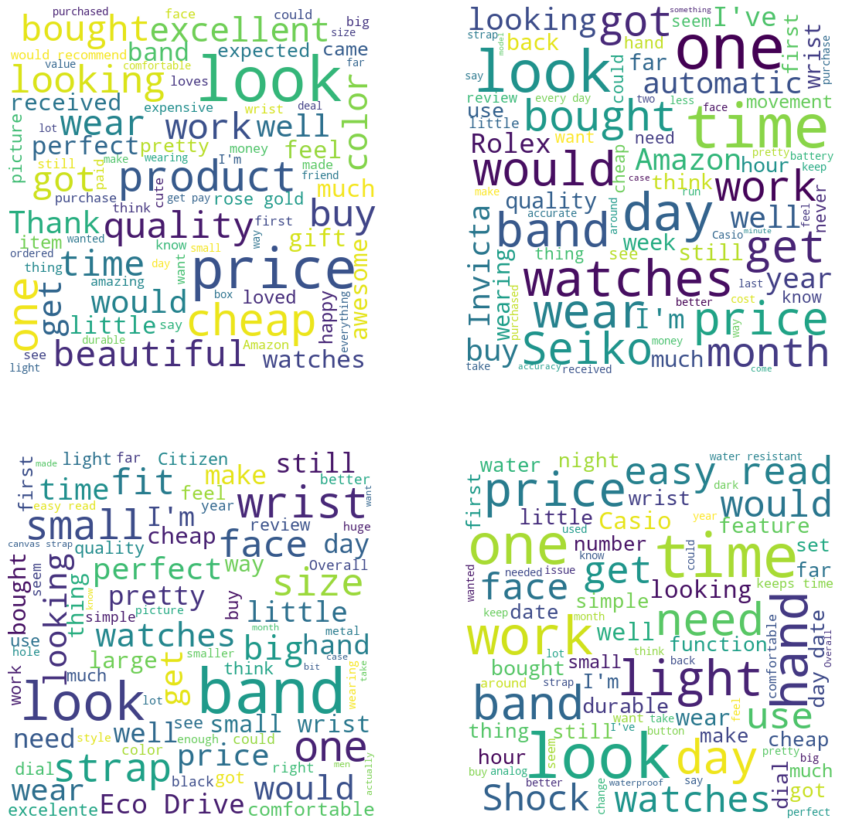

In [287]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.figure(figsize = (15,15))
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    cluster_reviews = review_topic_df[review_topic_df.topic==i].review.tolist()
    wordcloud = getWordCloud(", ".join(cluster_reviews))
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")

In [288]:
import seaborn as sns

<AxesSubplot:xlabel='topic', ylabel='count'>

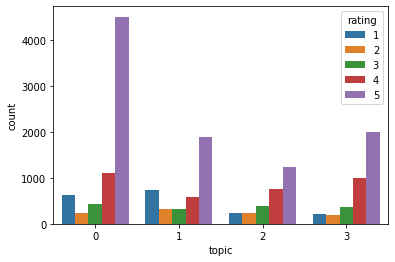

In [289]:
sns.countplot(data = review_topic_df, x = 'topic', hue = 'rating')

<AxesSubplot:xlabel='count', ylabel='product_id'>

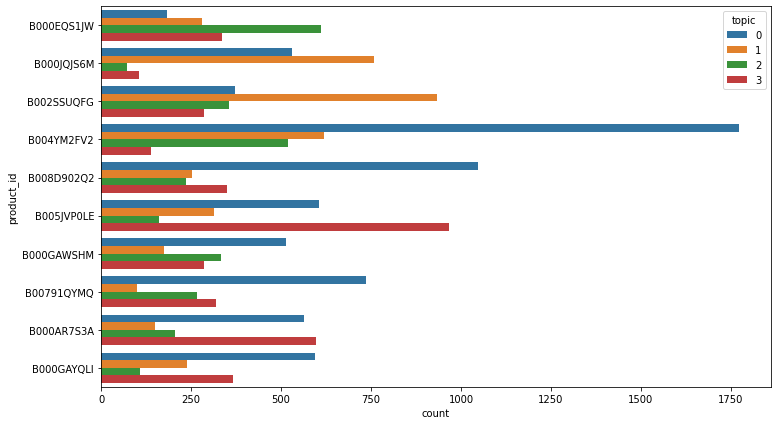

In [290]:
plt.figure(figsize = (12, 7))
sns.countplot(data = review_topic_df, y = 'product_id', hue = 'topic')

In [291]:
review_topic_df_group = review_topic_df.groupby([ 'topic','product_id',
                                                 'product_title', 'rating']).count().unstack().reset_index()

In [292]:
review_topic_df_group.columns = review_topic_df_group.columns.droplevel(1)

In [293]:
review_topic_df_group.columns = ['topic', 'product_id','product_title', '1', '2', '3', '4', '5']
review_topic_df_group.head()

,topic,product_id,product_title,1,2,3,4,5
0,0,B000AR7S3A,G-Shock G100-1BV Men's Black Resin Sport Watch,6.0,5.0,19.0,86.0,448.0
1,0,B000EQS1JW,Citizen Men's BM8180-03E Eco-Drive Stainless S...,2.0,NaN,2.0,21.0,158.0
2,0,B000GAWSHM,Casio Men's MQ24-1E Black Resin Watch,47.0,26.0,42.0,90.0,310.0
3,0,B000GAYQLI,Casio Sport Watch,4.0,3.0,10.0,82.0,496.0
4,0,B000JQJS6M,Invicta Men's 8928OB Pro Diver Gold Stainless ...,9.0,8.0,16.0,80.0,417.0


In [294]:
# change the number to percentage
review_topic_df_group[['1', '2', '3', '4', '5']] = review_topic_df_group[['1', '2', '3', '4', '5']].apply(lambda x: x/x.sum(), axis=1)
review_topic_df_group.head()

,topic,product_id,product_title,1,2,3,4,5
0,0,B000AR7S3A,G-Shock G100-1BV Men's Black Resin Sport Watch,0.010638,0.008865,0.033688,0.152482,0.794326
1,0,B000EQS1JW,Citizen Men's BM8180-03E Eco-Drive Stainless S...,0.010929,NaN,0.010929,0.114754,0.863388
2,0,B000GAWSHM,Casio Men's MQ24-1E Black Resin Watch,0.091262,0.050485,0.081553,0.174757,0.601942
3,0,B000GAYQLI,Casio Sport Watch,0.006723,0.005042,0.016807,0.137815,0.833613
4,0,B000JQJS6M,Invicta Men's 8928OB Pro Diver Gold Stainless ...,0.016981,0.015094,0.030189,0.150943,0.786792


In [295]:
recommend = review_topic_df_group[['topic', 'product_id','product_title', '5']].\
            loc[review_topic_df_group.groupby(["topic"])["5"].idxmax()] 
recommend

,topic,product_id,product_title,5
1,0,B000EQS1JW,Citizen Men's BM8180-03E Eco-Drive Stainless S...,0.863388
10,1,B000AR7S3A,G-Shock G100-1BV Men's Black Resin Sport Watch,0.721854
23,2,B000GAYQLI,Casio Sport Watch,0.607477
33,3,B000GAYQLI,Casio Sport Watch,0.683060
